In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/patents/training_set_patents_disambiguation_V1.tsv


In [4]:
# load the patents dataset
patents = pd.read_csv('/kaggle/input/patents/training_set_patents_disambiguation_V1.tsv', sep='\t')

# drop unused columns
drop_columns = ['Unnamed: 0', 'disambig_inventor_name_first', 'disambig_inventor_name_last', 'patent_title', 'patent_abstract']
patents = patents.drop(drop_columns, axis=1)

# merge title_encoded and abstract_encoded into text_encoded
patents['patent_text_encoded'] = patents['patent_title_encoded'] + patents['patent_abstract_encoded']

# show the dataframe
patents.head(5)

,patent_id,inventor_id,patent_date,patent_title_encoded,patent_abstract_encoded,patent_text_encoded
0,10000008,fl:li_ln:caspi-2,2018-06-19,[-0.033 0.094 0.013 -0.038 -0.114 -0.022 0....,[-0.047 0.042 0. 0.02 -0.094 0.016 0....,[-0.033 0.094 0.013 -0.038 -0.114 -0.022 0....
1,10000021,fl:is_ln:fuwa-1,2018-06-19,[ 0.034 -0.032 -0.061 -0.043 -0.09 -0.094 -0....,[-0. -0.028 -0.032 -0.025 -0.074 -0.036 -0....,[ 0.034 -0.032 -0.061 -0.043 -0.09 -0.094 -0....
2,10000023,fl:al_ln:elsiblani-1,2018-06-19,[ 0.004 -0.061 -0.053 -0.036 -0.128 -0.056 -0....,[-0.035 -0.039 -0.015 -0.043 -0.108 -0.057 0....,[ 0.004 -0.061 -0.053 -0.036 -0.128 -0.056 -0....
3,10000030,fl:ma_ln:ohara-21,2018-06-19,[-0.073 0.05 -0.06 -0.043 -0.048 -0.054 -0....,[ 0.032 0.008 0.004 -0.028 0.02 -0.011 -0....,[-0.073 0.05 -0.06 -0.043 -0.048 -0.054 -0....
4,10000038,fl:no_ln:mukai-13,2018-06-19,[-0.07 0.038 -0.033 0.043 -0.058 -0.005 0....,[-0.073 0.074 0.032 -0.003 0.025 0.029 0....,[-0.07 0.038 -0.033 0.043 -0.058 -0.005 0....


In [5]:
patents.tail()

,patent_id,inventor_id,patent_date,patent_title_encoded,patent_abstract_encoded,patent_text_encoded
6348,10034505,fl:gr_ln:sesselmann-1,2018-07-31,[ 0.006 -0.018 0.029 0.009 0.046 0.015 0....,[-0.011 0.082 0.098 0.103 0.151 0.029 0....,[ 0.006 -0.018 0.029 0.009 0.046 0.015 0....
6349,10034506,fl:gr_ln:sesselmann-1,2018-07-31,[ 0.006 -0.018 0.029 0.009 0.046 0.015 0....,[-0.048 0.087 0.09 0.073 0.115 0.013 0....,[ 0.006 -0.018 0.029 0.009 0.046 0.015 0....
6350,10034507,fl:ph_ln:thomas-24,2018-07-31,[-0.097 0.049 0.015 -0.059 -0.015 0.015 0....,[-0.054 -0.002 0.077 -0.026 0.031 -0.037 0....,[-0.097 0.049 0.015 -0.059 -0.015 0.015 0....
6351,10034510,fl:er_ln:sommers-1,2018-07-31,[-0.077 0.105 -0.026 -0.071 0.079 0.028 0....,[-0.055 0.076 0.013 -0.04 0.022 0.076 0....,[-0.077 0.105 -0.026 -0.071 0.079 0.028 0....
6352,10034514,fl:ja_ln:meschter-1,2018-07-31,[-0.073 0.032 0.04 0.003 0.044 -0.011 0....,[-0.029 -0.005 0.086 0.002 0.052 0.015 0....,[-0.073 0.032 0.04 0.003 0.044 -0.011 0....


In [6]:
# convert word vector to a cleaned numpy array
def preprocess_data(df: pd.DataFrame, column_name: str) -> pd.DataFrame:
    
    # Make a copy of the dataframe to avoid changing the original one
    df_copy = df.copy()

    for i in range(len(df_copy[column_name])):

        data = df_copy[column_name][i].strip('[]').replace('][', ' ')

        # Split by spaces
        data = data.split()

        # Convert strings to float32
        data = np.array(data, dtype=np.float32)

        # Assign the preprocessed data back to the DataFrame
        df_copy.at[i, column_name] = data

    return df_copy

In [7]:
patents = preprocess_data(patents, 'patent_title_encoded')
patents = preprocess_data(patents, 'patent_abstract_encoded')
patents = preprocess_data(patents, 'patent_text_encoded')

In [8]:
inventor_counts = patents['inventor_id'].value_counts()
inventor_counts

fl:ae_ln:dudar-1            15
fl:ge_ln:vanlieshout-2      12
fl:ho_ln:zhang-167          12
fl:al_ln:reznicek-1         12
fl:eu_ln:lee-264            12
                            ..
fl:bi_ln:bhattacharyya-5     2
fl:ke_ln:ash-7               2
fl:an_ln:smith-44            2
fl:an_ln:freed-1             2
fl:gr_ln:sesselmann-1        2
Name: inventor_id, Length: 2663, dtype: int64

In [9]:
import random
import pandas as pd

def prepare_triplet_data(data):
    # Initialize empty lists for anchor, positive, and negative samples
    anchor_samples = []
    positive_samples = []
    negative_samples = []

    # Group data by inventor_id
    grouped_data = data.groupby('inventor_id')

    for group_name, group_data in grouped_data:
        # If the group has only one sample, skip it (cannot form positive pair)
        if len(group_data) < 2:
            continue

        # Get the indices of the group samples
        group_indices = group_data.index.tolist()
        positive_candidates = group_data.index.tolist()

        for anchor_index in group_indices:
            anchor_sample = data.loc[[anchor_index]]
#             print("current anchor sample: ", anchor_sample)
          
            # Remove the anchor index from the positive_candidates list
            positive_candidates_modified = positive_candidates.copy()

            if anchor_index in positive_candidates:
                positive_candidates_modified.remove(anchor_index)
            
#             print("positive candidates list: ", positive_candidates_modified)
            
            if len(positive_candidates_modified) == 0:
                dummy_group_indices = group_indices.copy()
                dummy_group_indices.remove(anchor_index)
                positive_index = random.choice(dummy_group_indices)
#                 print("chosed positive sample: ", positive_index)
           
            else:
                # Select a random positive index from the modified positive_candidates list
                positive_index = random.choice(positive_candidates_modified)
#                 print("chosed positive sample: ", positive_index)
                positive_sample = data.loc[[positive_index]]
                positive_candidates.remove(positive_index)

            # Select a random negative index from a different group
            negative_group_names = list(grouped_data.groups.keys())
            negative_group_names.remove(group_name)
            negative_group_name = random.choice(negative_group_names)
            negative_group = grouped_data.get_group(negative_group_name)
            negative_sample = negative_group.sample(n=1)

            # Append samples to the respective lists
            anchor_samples.append(anchor_sample)
            positive_samples.append(positive_sample)
            negative_samples.append(negative_sample)

    # Concatenate the anchor, positive, and negative samples
    anchor_data = pd.concat(anchor_samples)
    positive_data = pd.concat(positive_samples)
    negative_data = pd.concat(negative_samples)

    return anchor_data, positive_data, negative_data


In [10]:
anchor_patent, positive_patent, negative_patent = prepare_triplet_data(patents)

In [11]:
anchor_patent

,patent_id,inventor_id,patent_date,patent_title_encoded,patent_abstract_encoded,patent_text_encoded
3882,10021135,fl:a._ln:uluagac-1,2018-07-10,"[-0.092, 0.071, 0.014, 0.036, 0.022, -0.036, 0...","[-0.076, 0.136, 0.024, 0.015, -0.03, -0.017, 0...","[-0.092, 0.071, 0.014, 0.036, 0.022, -0.036, 0..."
5052,10027697,fl:a._ln:uluagac-1,2018-07-17,"[-0.05, 0.045, -0.039, -0.12, 0.007, -0.086, 0...","[-0.059, 0.057, -0.046, -0.001, 0.047, -0.042,...","[-0.05, 0.045, -0.039, -0.12, 0.007, -0.086, 0..."
66,10000534,fl:a_ln:han-3,2018-06-19,"[-0.08, -0.11, -0.119, 0.001, -0.043, 0.026, -...","[-0.146, -0.09, -0.088, -0.042, -0.007, 0.095,...","[-0.08, -0.11, -0.119, 0.001, -0.043, 0.026, -..."
5482,10030050,fl:a_ln:han-3,2018-07-24,"[-0.047, -0.093, -0.056, 0.005, 0.014, -0.018,...","[-0.058, -0.02, -0.029, -0.038, -0.029, 0.056,...","[-0.047, -0.093, -0.056, 0.005, 0.014, -0.018,..."
2172,10011931,fl:aa_ln:amstutz-1,2018-07-03,"[-0.048, -0.011, -0.01, -0.042, -0.065, -0.0, ...","[-0.059, -0.06, 0.011, -0.042, 0.011, 0.044, 0...","[-0.048, -0.011, -0.01, -0.042, -0.065, -0.0, ..."
...,...,...,...,...,...,...
4953,10027329,fl:zh_ln:wu-294,2018-07-17,"[0.006, 0.041, -0.047, -0.067, -0.085, -0.007,...","[-0.089, 0.026, -0.014, -0.027, -0.019, -0.052...","[0.006, 0.041, -0.047, -0.067, -0.085, -0.007,..."
5875,10032409,fl:zh_ln:wu-294,2018-07-24,"[-0.084, 0.081, 0.014, -0.034, 0.034, -0.043, ...","[-0.075, 0.033, 0.017, -0.015, 0.027, -0.053, ...","[-0.084, 0.081, 0.014, -0.034, 0.034, -0.043, ..."
794,10004262,fl:zh_ln:xiang-28,2018-06-26,"[-0.051, 0.18, -0.058, -0.002, -0.069, -0.003,...","[-0.05, 0.155, -0.042, -0.009, -0.043, 0.039, ...","[-0.051, 0.18, -0.058, -0.002, -0.069, -0.003,..."
800,10004269,fl:zh_ln:xiang-28,2018-06-26,"[-0.054, 0.12, -0.062, 0.007, -0.064, 0.088, 0...","[-0.044, 0.026, -0.08, -0.01, -0.012, 0.056, 0...","[-0.054, 0.12, -0.062, 0.007, -0.064, 0.088, 0..."


In [12]:
positive_patent

,patent_id,inventor_id,patent_date,patent_title_encoded,patent_abstract_encoded,patent_text_encoded
5052,10027697,fl:a._ln:uluagac-1,2018-07-17,"[-0.05, 0.045, -0.039, -0.12, 0.007, -0.086, 0...","[-0.059, 0.057, -0.046, -0.001, 0.047, -0.042,...","[-0.05, 0.045, -0.039, -0.12, 0.007, -0.086, 0..."
3882,10021135,fl:a._ln:uluagac-1,2018-07-10,"[-0.092, 0.071, 0.014, 0.036, 0.022, -0.036, 0...","[-0.076, 0.136, 0.024, 0.015, -0.03, -0.017, 0...","[-0.092, 0.071, 0.014, 0.036, 0.022, -0.036, 0..."
5482,10030050,fl:a_ln:han-3,2018-07-24,"[-0.047, -0.093, -0.056, 0.005, 0.014, -0.018,...","[-0.058, -0.02, -0.029, -0.038, -0.029, 0.056,...","[-0.047, -0.093, -0.056, 0.005, 0.014, -0.018,..."
66,10000534,fl:a_ln:han-3,2018-06-19,"[-0.08, -0.11, -0.119, 0.001, -0.043, 0.026, -...","[-0.146, -0.09, -0.088, -0.042, -0.007, 0.095,...","[-0.08, -0.11, -0.119, 0.001, -0.043, 0.026, -..."
4418,10024350,fl:aa_ln:amstutz-1,2018-07-17,"[-0.071, -0.039, 0.01, -0.005, 0.011, -0.069, ...","[-0.019, -0.07, 0.008, 0.052, -0.047, 0.016, 0...","[-0.071, -0.039, 0.01, -0.005, 0.011, -0.069, ..."
...,...,...,...,...,...,...
5875,10032409,fl:zh_ln:wu-294,2018-07-24,"[-0.084, 0.081, 0.014, -0.034, 0.034, -0.043, ...","[-0.075, 0.033, 0.017, -0.015, 0.027, -0.053, ...","[-0.084, 0.081, 0.014, -0.034, 0.034, -0.043, ..."
4953,10027329,fl:zh_ln:wu-294,2018-07-17,"[0.006, 0.041, -0.047, -0.067, -0.085, -0.007,...","[-0.089, 0.026, -0.014, -0.027, -0.019, -0.052...","[0.006, 0.041, -0.047, -0.067, -0.085, -0.007,..."
800,10004269,fl:zh_ln:xiang-28,2018-06-26,"[-0.054, 0.12, -0.062, 0.007, -0.064, 0.088, 0...","[-0.044, 0.026, -0.08, -0.01, -0.012, 0.056, 0...","[-0.054, 0.12, -0.062, 0.007, -0.064, 0.088, 0..."
794,10004262,fl:zh_ln:xiang-28,2018-06-26,"[-0.051, 0.18, -0.058, -0.002, -0.069, -0.003,...","[-0.05, 0.155, -0.042, -0.009, -0.043, 0.039, ...","[-0.051, 0.18, -0.058, -0.002, -0.069, -0.003,..."


In [13]:
anchor_patent['sample_id'] = anchor_patent.index
anchor_patent.reset_index(drop=True, inplace=True)
anchor_patent

,patent_id,inventor_id,patent_date,patent_title_encoded,patent_abstract_encoded,patent_text_encoded,sample_id
0,10021135,fl:a._ln:uluagac-1,2018-07-10,"[-0.092, 0.071, 0.014, 0.036, 0.022, -0.036, 0...","[-0.076, 0.136, 0.024, 0.015, -0.03, -0.017, 0...","[-0.092, 0.071, 0.014, 0.036, 0.022, -0.036, 0...",3882
1,10027697,fl:a._ln:uluagac-1,2018-07-17,"[-0.05, 0.045, -0.039, -0.12, 0.007, -0.086, 0...","[-0.059, 0.057, -0.046, -0.001, 0.047, -0.042,...","[-0.05, 0.045, -0.039, -0.12, 0.007, -0.086, 0...",5052
2,10000534,fl:a_ln:han-3,2018-06-19,"[-0.08, -0.11, -0.119, 0.001, -0.043, 0.026, -...","[-0.146, -0.09, -0.088, -0.042, -0.007, 0.095,...","[-0.08, -0.11, -0.119, 0.001, -0.043, 0.026, -...",66
3,10030050,fl:a_ln:han-3,2018-07-24,"[-0.047, -0.093, -0.056, 0.005, 0.014, -0.018,...","[-0.058, -0.02, -0.029, -0.038, -0.029, 0.056,...","[-0.047, -0.093, -0.056, 0.005, 0.014, -0.018,...",5482
4,10011931,fl:aa_ln:amstutz-1,2018-07-03,"[-0.048, -0.011, -0.01, -0.042, -0.065, -0.0, ...","[-0.059, -0.06, 0.011, -0.042, 0.011, 0.044, 0...","[-0.048, -0.011, -0.01, -0.042, -0.065, -0.0, ...",2172
...,...,...,...,...,...,...,...
6348,10027329,fl:zh_ln:wu-294,2018-07-17,"[0.006, 0.041, -0.047, -0.067, -0.085, -0.007,...","[-0.089, 0.026, -0.014, -0.027, -0.019, -0.052...","[0.006, 0.041, -0.047, -0.067, -0.085, -0.007,...",4953
6349,10032409,fl:zh_ln:wu-294,2018-07-24,"[-0.084, 0.081, 0.014, -0.034, 0.034, -0.043, ...","[-0.075, 0.033, 0.017, -0.015, 0.027, -0.053, ...","[-0.084, 0.081, 0.014, -0.034, 0.034, -0.043, ...",5875
6350,10004262,fl:zh_ln:xiang-28,2018-06-26,"[-0.051, 0.18, -0.058, -0.002, -0.069, -0.003,...","[-0.05, 0.155, -0.042, -0.009, -0.043, 0.039, ...","[-0.051, 0.18, -0.058, -0.002, -0.069, -0.003,...",794
6351,10004269,fl:zh_ln:xiang-28,2018-06-26,"[-0.054, 0.12, -0.062, 0.007, -0.064, 0.088, 0...","[-0.044, 0.026, -0.08, -0.01, -0.012, 0.056, 0...","[-0.054, 0.12, -0.062, 0.007, -0.064, 0.088, 0...",800


In [14]:
positive_patent['sample_id'] = positive_patent.index
positive_patent.reset_index(drop=True, inplace=True)
positive_patent

,patent_id,inventor_id,patent_date,patent_title_encoded,patent_abstract_encoded,patent_text_encoded,sample_id
0,10027697,fl:a._ln:uluagac-1,2018-07-17,"[-0.05, 0.045, -0.039, -0.12, 0.007, -0.086, 0...","[-0.059, 0.057, -0.046, -0.001, 0.047, -0.042,...","[-0.05, 0.045, -0.039, -0.12, 0.007, -0.086, 0...",5052
1,10021135,fl:a._ln:uluagac-1,2018-07-10,"[-0.092, 0.071, 0.014, 0.036, 0.022, -0.036, 0...","[-0.076, 0.136, 0.024, 0.015, -0.03, -0.017, 0...","[-0.092, 0.071, 0.014, 0.036, 0.022, -0.036, 0...",3882
2,10030050,fl:a_ln:han-3,2018-07-24,"[-0.047, -0.093, -0.056, 0.005, 0.014, -0.018,...","[-0.058, -0.02, -0.029, -0.038, -0.029, 0.056,...","[-0.047, -0.093, -0.056, 0.005, 0.014, -0.018,...",5482
3,10000534,fl:a_ln:han-3,2018-06-19,"[-0.08, -0.11, -0.119, 0.001, -0.043, 0.026, -...","[-0.146, -0.09, -0.088, -0.042, -0.007, 0.095,...","[-0.08, -0.11, -0.119, 0.001, -0.043, 0.026, -...",66
4,10024350,fl:aa_ln:amstutz-1,2018-07-17,"[-0.071, -0.039, 0.01, -0.005, 0.011, -0.069, ...","[-0.019, -0.07, 0.008, 0.052, -0.047, 0.016, 0...","[-0.071, -0.039, 0.01, -0.005, 0.011, -0.069, ...",4418
...,...,...,...,...,...,...,...
6348,10032409,fl:zh_ln:wu-294,2018-07-24,"[-0.084, 0.081, 0.014, -0.034, 0.034, -0.043, ...","[-0.075, 0.033, 0.017, -0.015, 0.027, -0.053, ...","[-0.084, 0.081, 0.014, -0.034, 0.034, -0.043, ...",5875
6349,10027329,fl:zh_ln:wu-294,2018-07-17,"[0.006, 0.041, -0.047, -0.067, -0.085, -0.007,...","[-0.089, 0.026, -0.014, -0.027, -0.019, -0.052...","[0.006, 0.041, -0.047, -0.067, -0.085, -0.007,...",4953
6350,10004269,fl:zh_ln:xiang-28,2018-06-26,"[-0.054, 0.12, -0.062, 0.007, -0.064, 0.088, 0...","[-0.044, 0.026, -0.08, -0.01, -0.012, 0.056, 0...","[-0.054, 0.12, -0.062, 0.007, -0.064, 0.088, 0...",800
6351,10004262,fl:zh_ln:xiang-28,2018-06-26,"[-0.051, 0.18, -0.058, -0.002, -0.069, -0.003,...","[-0.05, 0.155, -0.042, -0.009, -0.043, 0.039, ...","[-0.051, 0.18, -0.058, -0.002, -0.069, -0.003,...",794


In [15]:
negative_patent['sample_id'] = negative_patent.index
negative_patent.reset_index(drop=True, inplace=True)
negative_patent

,patent_id,inventor_id,patent_date,patent_title_encoded,patent_abstract_encoded,patent_text_encoded,sample_id
0,10009217,fl:as_ln:attarde-2,2018-06-26,"[0.03, -0.051, 0.07, 0.013, 0.034, -0.028, 0.0...","[-0.044, 0.014, -0.067, 0.0, -0.022, 0.067, -0...","[0.03, -0.051, 0.07, 0.013, 0.034, -0.028, 0.0...",1665
1,10015635,fl:ja_ln:bostick-2,2018-07-03,"[0.029, -0.018, 0.055, -0.067, 0.041, -0.032, ...","[0.021, -0.086, -0.039, -0.062, 0.069, -0.033,...","[0.029, -0.018, 0.055, -0.067, 0.041, -0.032, ...",2892
2,10029206,fl:ch_ln:spadaccini-1,2018-07-24,"[0.04, -0.024, -0.021, 0.005, 0.124, 0.05, 0.0...","[-0.019, -0.019, 0.03, -0.05, 0.083, 0.034, 0....","[0.04, -0.024, -0.021, 0.005, 0.124, 0.05, 0.0...",5364
3,10005372,fl:ta_ln:lee-180,2018-06-26,"[-0.004, 0.09, -0.06, 0.01, 0.052, 0.021, 0.05...","[-0.06, -0.008, -0.047, 0.056, -0.03, 0.061, -...","[-0.004, 0.09, -0.06, 0.01, 0.052, 0.021, 0.05...",958
4,10030450,fl:an_ln:digiovanni-5,2018-07-24,"[-0.015, -0.017, 0.013, 0.027, -0.056, -0.061,...","[-0.042, -0.018, 0.063, 0.009, -0.089, 0.012, ...","[-0.015, -0.017, 0.013, 0.027, -0.056, -0.061,...",5528
...,...,...,...,...,...,...,...
6348,10031425,fl:hi_ln:hirota-11,2018-07-24,"[0.009, 0.028, 0.042, 0.03, 0.009, -0.038, 0.0...","[-0.073, -0.0, 0.051, 0.073, 0.046, 0.015, 0.1...","[0.009, 0.028, 0.042, 0.03, 0.009, -0.038, 0.0...",5669
6349,10007757,fl:br_ln:corbin-3,2018-06-26,"[-0.074, 0.019, -0.025, 0.083, -0.132, 0.003, ...","[-0.083, 0.093, -0.035, -0.012, -0.093, 0.038,...","[-0.074, 0.019, -0.025, 0.083, -0.132, 0.003, ...",1360
6350,10022693,fl:an_ln:tong-5,2018-07-17,"[-0.04, 0.063, -0.009, 0.037, 0.063, -0.016, -...","[-0.03, 0.022, -0.117, 0.008, 0.035, 0.008, 0....","[-0.04, 0.063, -0.009, 0.037, 0.063, -0.016, -...",4183
6351,10008322,fl:aj_ln:kumar-10,2018-06-26,"[-0.037, 0.091, -0.028, -0.03, -0.033, -0.024,...","[-0.048, 0.06, 0.01, -0.03, 0.018, -0.008, 0.0...","[-0.037, 0.091, -0.028, -0.03, -0.033, -0.024,...",1446


In [16]:
import random

# Assuming three parallel datasets: dataset1, dataset2, dataset3

# Create a list of indices
indices = list(range(len(anchor_patent)))

# Shuffle the indices randomly
random.shuffle(indices)


# Define the split ratio (e.g., 80% for training, 20% for testing)
train_ratio = 0.8
train_size = int(train_ratio * len(indices))

# Split the indices into train and test sets
train_indices = indices[:train_size]
test_indices = indices[train_size:]

# Use the train and test indices to split the datasets
anchor_train = anchor_patent.iloc[train_indices]
positive_train= positive_patent.iloc[train_indices]
negative_train = negative_patent.iloc[train_indices]

anchor_test = anchor_patent.iloc[test_indices]
positive_test = positive_patent.iloc[test_indices]
negative_test = negative_patent.iloc[test_indices]


In [17]:
def convert_to_numpy_array(df_train: pd.DataFrame, df_test: pd.DataFrame, column_name: str):
    # Convert train data to a single numpy array
    train_data = np.array(df_train[column_name])
    train_data = np.vstack(train_data)

    # Convert test data to a single numpy array
    test_data = np.array(df_test[column_name])
    test_data = np.vstack(test_data)
    
    return train_data, test_data

In [18]:
anchor_train_data, anchor_test_data = convert_to_numpy_array(anchor_train, anchor_test, 'patent_abstract_encoded')
positive_train_data, positive_test_data = convert_to_numpy_array(positive_train, positive_test, 'patent_abstract_encoded')
negative_train_data, negative_test_data = convert_to_numpy_array(negative_train, negative_test, 'patent_abstract_encoded')

In [19]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from keras import backend as K
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, Lambda, concatenate
from keras.optimizers import RMSprop
from keras import regularizers

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [20]:
# Create a batch of base neural networks
# MLP, 1D-CNN, LSTM, GRU, RNN, Transformer

# simple MLP

def base_MLP(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape= (input_shape,)))
    model.add(Dropout(0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(128, activation='relu'))

    return model

# 1d-CNN

from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dropout
from tensorflow.keras.models import Sequential

def base_CNN(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    model = Sequential()
    model.add(Conv1D(128, 5, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(2))
    model.add(Dropout(0.1))
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(Dropout(0.1))
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(GlobalAveragePooling1D())
    
    return model

# LSTM
from keras.layers import LSTM
def base_LSTM(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.1))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.1))
    model.add(LSTM(128, return_sequences=False))
    
    return model

# GRU 
from keras.layers import GRU

def base_GRU(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    model = Sequential()
    model.add(GRU(128, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.1))
    model.add(GRU(128, return_sequences=True))
    model.add(Dropout(0.1))
    model.add(GRU(128, return_sequences=False))
    
    return model

# Simple RNN

from keras.layers import SimpleRNN

def base_RNN(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    model = Sequential()
    model.add(SimpleRNN(128, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.1))
    model.add(SimpleRNN(128, return_sequences=True))
    model.add(Dropout(0.1))
    model.add(SimpleRNN(128, return_sequences=False))
    
    return model

In [21]:
# Distance/Similarity calculating functions

def euclidean_distance(x1, x2):
    return tf.norm(x1 - x2, axis=-1)

def cosine_similarity(x1, x2):
    x1 = K.l2_normalize(x1, axis=-1)
    x2 = K.l2_normalize(x2, axis=-1)
    return 1.0 - K.sum(x1 * x2, axis=-1)

In [22]:
# Loss functions

def triplet_loss(_, distances):
    margin = 0.5
    distance_positive = distances[1]
    distance_negative = distances[2]
    loss = K.mean(K.maximum(distance_positive - distance_negative + margin, 0.0))
    return loss

In [23]:
# Create the Siamese network model with the base model

def siamese_network(base_model, distance_fn):
    input_anchor = Input(shape=base_model.input_shape[1:])
    input_positive = Input(shape=base_model.input_shape[1:])
    input_negative = Input(shape=base_model.input_shape[1:])
    
    embedded_anchor = base_model(input_anchor)
    embedded_positive = base_model(input_positive)
    embedded_negative = base_model(input_negative)

    # Distance calculation using the provided distance function
    distance_positive = Lambda(lambda x: distance_fn(x[0], x[1]), name='pos_dist')([embedded_anchor, embedded_positive])
    distance_negative = Lambda(lambda x: distance_fn(x[0], x[1]), name='neg_dist')([embedded_anchor, embedded_negative])
    
    # Concatenate the outputs
    merged_output = Concatenate()([embedded_anchor, embedded_positive, embedded_negative])

    # Model combining anchor, positive, and negative inputs
    siamese_model = Model(inputs=[input_anchor, input_positive, input_negative], outputs=[merged_output, distance_positive, distance_negative])

    return siamese_model

In [24]:
import tensorflow as tf
import os

def train_siamese_network(anchor_data, positive_data, negative_data, base_model, batch_size, epochs, 
                          distance_fn, use_gpu=True, use_tpu=False):
    
    if use_gpu:
        siamese_model = siamese_network(base_model, distance_fn)
        siamese_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=[None, triplet_loss, triplet_loss], loss_weights=[0, 1, 1])
        
    elif use_tpu:
        # Code for TPU training
        tpu_resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(tpu_resolver)
        tf.tpu.experimental.initialize_tpu_system(tpu_resolver)
        strategy = tf.distribute.TPUStrategy(tpu_resolver)
        
        with strategy.scope():
            siamese_model = siamese_network(base_model, distance_fn)
            siamese_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=[None, triplet_loss, triplet_loss], loss_weights=[0, 1, 1])
    
    else:
        siamese_model = siamese_network(base_model, distance_fn)
        siamese_model.compile(optimizer='adam', loss=[None, triplet_loss, triplet_loss], loss_weights=[0, 1, 1])

    dummy_target = np.zeros((anchor_data.shape[0], 1), dtype=np.float32)

    siamese_model.fit([anchor_data, positive_data, negative_data], 
                      [dummy_target, dummy_target, dummy_target], 
                       batch_size=batch_size, epochs=epochs, verbose=1)

    return siamese_model

In [25]:
from sklearn.metrics import silhouette_score

def evaluate_clustering(anchor_test_data, num_clusters, siamese_models, base_model_names, distance_fn_names):
    silhouette_scores = []
    table_data = []
    
    num_models = len(siamese_models)

    for i, model in enumerate(siamese_models):

        anchor_test_embeddings = model.layers[3](anchor_test_data)

        kmeans = KMeans(n_clusters=num_clusters, random_state=48).fit(anchor_test_embeddings)
        labels = kmeans.labels_

        silhouette = silhouette_score(anchor_test_embeddings, labels)
        silhouette_scores.append(silhouette)
        
        base_model_name = base_model_names[i // len(distance_fn_names)]
        distance_fn_name = distance_fn_names[i % len(distance_fn_names)]
        combination = f'Model {i+1}: {base_model_name} with {distance_fn_name}'

        print(f'Silhouette Score: {silhouette}')
        pca = PCA(n_components=2)
        principalComponents = pca.fit_transform(anchor_test_embeddings)
        principalDf = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2'])
        plt.figure(figsize=(8,6))
        plt.scatter(principalDf['principal component 1'], principalDf['principal component 2'], c=labels)
        plt.title(combination)
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        
        #plt.savefig(combination +'.png')
        
        plt.show()

        table_data.append({'Model': combination, 'Silhouette Score': silhouette})

    table_df = pd.DataFrame(table_data)

    return silhouette_scores, table_df

In [26]:
from sklearn.metrics import silhouette_score

def evaluate_clustering(anchor_test_data, num_clusters, siamese_models, base_model_names, distance_fn_names):
    silhouette_scores = []
    table_data = []
    
    num_models = len(siamese_models)

    for i, model in enumerate(siamese_models):

        anchor_test_embeddings = model.layers[3](anchor_test_data)

        kmeans = KMeans(n_clusters=num_clusters, random_state=48).fit(anchor_test_embeddings)
        labels = kmeans.labels_

        silhouette = silhouette_score(anchor_test_embeddings, labels)
        silhouette_scores.append(silhouette)
        
        base_model_name = base_model_names[i // len(distance_fn_names)]
        distance_fn_name = distance_fn_names[i % len(distance_fn_names)]
        combination = f'Model {i+1}: {base_model_name} with {distance_fn_name}'

        print(f'Silhouette Score: {silhouette}')
        pca = PCA(n_components=2)
        principalComponents = pca.fit_transform(anchor_test_embeddings)
        principalDf = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2'])
        plt.figure(figsize=(8,6))
        plt.scatter(principalDf['principal component 1'], principalDf['principal component 2'], c=labels)
        plt.title(combination)
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        
        #plt.savefig(combination +'.png')
        
        plt.show()

        table_data.append({'Model': combination, 'Silhouette Score': silhouette})

    table_df = pd.DataFrame(table_data)

    return silhouette_scores, table_df

In [27]:
# Configurations
input_shape_ = anchor_train_data.shape[1]  # Shape of input data
input_dim = 1 # You might need to change this based on your data
input_shape = (input_shape_, input_dim)

batch_size = 32  # Batch size for training
epochs = 10  # Number of epochs for training
num_clusters = 5  # Number of clusters for K-means

# Define the base models and distance functions
base_models = [base_MLP(input_shape_), base_CNN(input_shape), base_LSTM(input_shape), base_RNN(input_shape)]
distance_fns = [euclidean_distance, cosine_similarity]

base_model = base_MLP(input_shape_)#base_CNN(input_shape)#base_LSTM(input_shape)
distance_fn = cosine_similarity

base_model_names = ['MLP', 'CNN', 'LSTM', 'RNN']
distance_fn_names = ['Euclidean Distance', 'Cosine Similarity']

In [28]:
# anchor_train_data = anchor_train_data.reshape(-1, input_shape_, input_dim)
# positive_train_data = positive_train_data.reshape(-1, input_shape_, input_dim)
# negative_train_data = negative_train_data.reshape(-1, input_shape_, input_dim)

In [29]:
siamese_model = train_siamese_network(anchor_train_data, positive_train_data, negative_train_data, base_model, batch_size, epochs, distance_fn)

Epoch 1/10
159/159 [==============================] - 3s 4ms/step - loss: 0.9808 - pos_dist_loss: 0.4876 - neg_dist_loss: 0.4932
Epoch 2/10
159/159 [==============================] - 1s 4ms/step - loss: 0.9942 - pos_dist_loss: 0.4995 - neg_dist_loss: 0.4947
Epoch 3/10
159/159 [==============================] - 1s 4ms/step - loss: 0.9898 - pos_dist_loss: 0.5048 - neg_dist_loss: 0.4851
Epoch 4/10
159/159 [==============================] - 1s 4ms/step - loss: 0.9993 - pos_dist_loss: 0.5033 - neg_dist_loss: 0.4960
Epoch 5/10
159/159 [==============================] - 1s 6ms/step - loss: 1.0029 - pos_dist_loss: 0.4994 - neg_dist_loss: 0.5036
Epoch 6/10
159/159 [==============================] - 1s 5ms/step - loss: 1.0041 - pos_dist_loss: 0.5004 - neg_dist_loss: 0.5037
Epoch 7/10
159/159 [==============================] - 1s 5ms/step - loss: 1.0057 - pos_dist_loss: 0.5032 - neg_dist_loss: 0.5026
Epoch 8/10
159/159 [==============================] - 1s 5ms/step - loss: 1.0046 - pos_dist_loss:

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score: 0.232804074883461


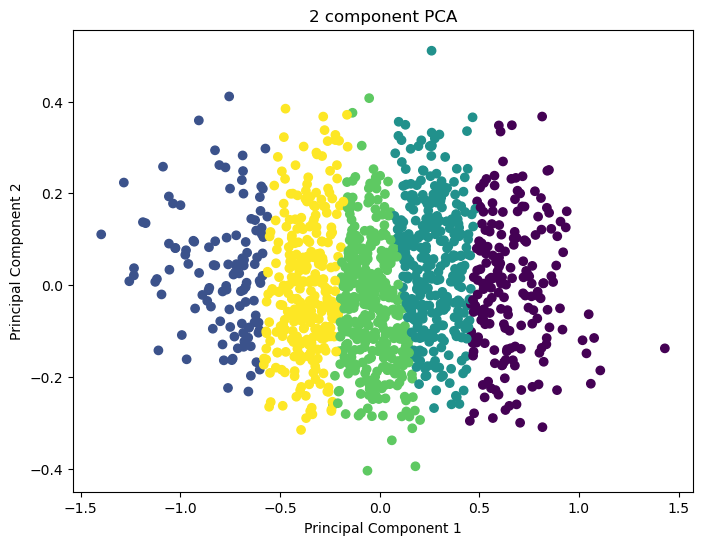

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1271 samples in 0.001s...
[t-SNE] Computed neighbors for 1271 samples in 0.076s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1271
[t-SNE] Computed conditional probabilities for sample 1271 / 1271
[t-SNE] Mean sigma: 0.091430
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.632610
[t-SNE] KL divergence after 300 iterations: 1.187941


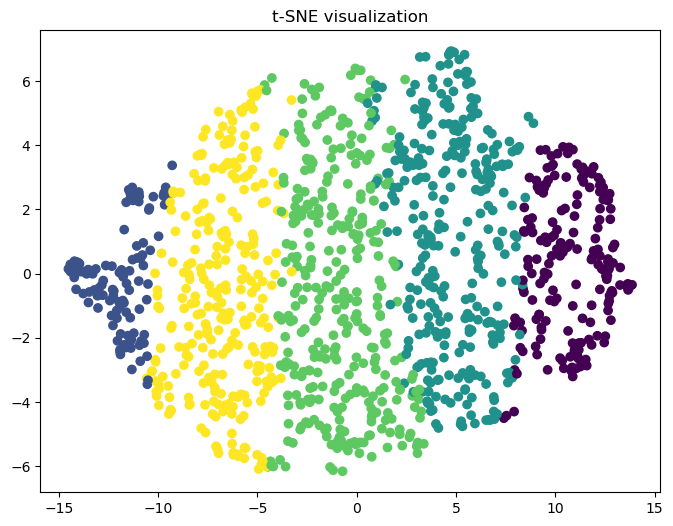

In [30]:
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

# Step 1: Compute embeddings of the test set
anchor_test_embeddings = siamese_model.layers[3](anchor_test_data)

# Step 2: Cluster the embeddings using K-means
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(anchor_test_embeddings)

# Step 3: Compute the Silhouette Score for the clustering
labels = kmeans.labels_
silhouette = silhouette_score(anchor_test_embeddings, labels)

print(f'Silhouette Score: {silhouette}')

# Step 4: Visualize the embeddings using PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(anchor_test_embeddings)
principalDf = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2'])
plt.figure(figsize=(8,6))
plt.scatter(principalDf['principal component 1'], principalDf['principal component 2'], c=labels)
plt.title('2 component PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Alternatively, you can use t-SNE for visualization
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(anchor_test_embeddings)
plt.figure(figsize=(8,6))
plt.scatter(tsne_results[:,0], tsne_results[:,1], c=labels)
plt.title('t-SNE visualization')
plt.show()

In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score

def calculate_metrics(y_true, y_pred):
    # Assuming y_true and y_pred are the true labels and predicted labels, respectively
    accuracy = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    # Add any other metrics you want to calculate

    return accuracy, auc, f1, precision

In [32]:
# Make predictions on the test data
_, distances_positive, distances_negative = siamese_model.predict([anchor_test_data, positive_test_data, negative_test_data])

40/40 [==============================] - 0s 2ms/step


In [44]:
threshold = 0.0025

In [45]:
# Convert similarity scores to predicted labels (1 for positive, 0 for negative)
y_pred_positive = np.array([1 if distance_positive <= threshold else 0 for distance_positive in distances_positive])
y_pred_negative = np.array([1 if distance_negative <= threshold else 0 for distance_negative in distances_negative])

In [47]:
# 1 for pairs invented by the same inventor, 0 otherwise
y_true_positive = np.array([1] * len(distances_positive))  # Replace with the true labels
# 1 for pairs invented by the same inventor, 0 otherwise
y_true_negative = np.array([0] * len(distances_negative))  # Replace with the true labels

In [36]:
distances_positive

array([0.00529969, 0.00385875, 0.0041557 , ..., 0.00223428, 0.00565362,
       0.00240588], dtype=float32)

In [43]:
distances_negative

array([0.00993025, 0.01054174, 0.00173724, ..., 0.00265068, 0.00765896,
       0.01161051], dtype=float32)

In [48]:
# Concatenate the arrays
y_true = np.concatenate((y_true_positive, y_true_negative))
y_pred = np.concatenate((y_pred_positive, y_pred_negative))

In [38]:
y_true_positive, y_pred_positive

(array([1, 1, 1, ..., 1, 1, 1]), array([0, 0, 0, ..., 0, 0, 0]))

In [49]:
# Calculate metrics
accuracy, auc, f1, precision = calculate_metrics(y_true, y_pred)

In [50]:
accuracy

0.6864673485444532

In [41]:
# Concatenate the arrays
y_true = np.concatenate((y_true_positive, y_true_negative))
y_pred = np.concatenate((y_pred_positive, y_pred_negative))

In [42]:
# Calculate metrics
accuracy_n, auc_n, f1_n, precision_n = calculate_metrics(y_true, y_pred)

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
